## Add Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.preprocessing import image

import splitfolders
import os
import shutil
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

## Read In Data

In [15]:
# pokedex
df1 = pd.read_csv("data/pokedex.csv", index_col=0)
df1["image_address"] = df1["image"]
df1 = df1.drop(columns = "image")

# pokedex4
df2 = pd.read_csv("data/pokedex2.csv", index_col=0)

# concat dataframes
df = pd.concat([df1, df2])
df = df.drop(columns = "type2")
df

,dex_no,name,type1,image_name,image_address
0,1.0,Bulbasaur,Grass,pokedex_bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
1,2.0,Ivysaur,Grass,pokedex_ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
2,3.0,Venusaur,Grass,pokedex_venusaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
3,4.0,Charmander,Fire,pokedex_charmander.jpg,https://img.pokemondb.net/sprites/home/normal/...
4,5.0,Charmeleon,Fire,pokedex_charmeleon.jpg,https://img.pokemondb.net/sprites/home/normal/...
...,...,...,...,...,...
1150,NaN,Iron_Valiant,Fairy,pokedex2_Iron_Valiant.png,archives.bulbagarden.net/media/upload/thumb/2/...
1151,NaN,Koraidon,Fighting,pokedex2_Koraidon.png,archives.bulbagarden.net/media/upload/thumb/a/...
1152,NaN,Miraidon,Electric,pokedex2_Miraidon.png,archives.bulbagarden.net/media/upload/thumb/1/...
1153,NaN,Walking_Wake,Water,pokedex2_Walking_Wake.png,archives.bulbagarden.net/media/upload/thumb/b/...


In [30]:
# make new dataframe out of all the images listed in the images folder
df_imagesonly = pd.DataFrame(os.listdir("data/images"))
df_imagesonly.columns = ["image_name"]
df_imagesonly["name"] = df_imagesonly["image_name"]
df_imagesonly["name"] = df_imagesonly["name"].str.replace(".png", "").str.replace(".jpg", "").str.replace(".svg", "")
df_imagesonly["name"] = df_imagesonly["name"].str.replace("\d+", "")
df_imagesonly["name"] = df_imagesonly["name"].str.capitalize()
df_imagesonly["name"] = df_imagesonly["name"].str.split("_").apply(lambda x: x[1])
df_imagesonly["name"] = df_imagesonly["name"].str.title()

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_3144/2797638038.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_imagesonly["name"] = df_imagesonly["name"].str.replace(".png", "").str.replace(".jpg", "").str.replace(".svg", "")
/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_3144/2797638038.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_imagesonly["name"] = df_imagesonly["name"].str.replace("\d+", "")


In [32]:
# create new dataframe for just names and types
names_and_types = df[["name", "type1"]]

# combine with df_imagesonly
images_types = df_imagesonly.merge(names_and_types)
images_types

,image_name,name,type1
0,dataset_Dodrio33.jpg,Dodrio,Normal
1,dataset_Dodrio33.jpg,Dodrio,Normal
2,dataset_Dodrio27.jpg,Dodrio,Normal
3,dataset_Dodrio27.jpg,Dodrio,Normal
4,dataset_Dodrio26.jpg,Dodrio,Normal
...,...,...,...
19664,pokedex2_Ninetales-Alola.png,Ninetales-Alola,Ice
19665,pokedex_burmy.jpg,Burmy,Bug
19666,pokedex2_Raichu-Alola.png,Raichu-Alola,Electric
19667,pokedex2_Eiscue-Noice.png,Eiscue-Noice,Ice


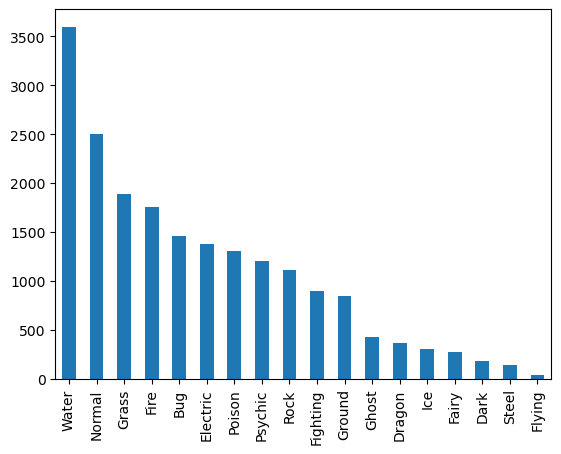

In [33]:
images_types.type1.value_counts().plot(kind='bar');

In [34]:
# remove rows that do not contain main types
main_types = ["Water", "Normal", "Grass", "Pyschic", "Bug", "Fire", "Poison", "Ground", "Fighting", "Rock"]
images_types = images_types[images_types['type1'].isin(main_types)]
images_types

,image_name,name,type1
0,dataset_Dodrio33.jpg,Dodrio,Normal
1,dataset_Dodrio33.jpg,Dodrio,Normal
2,dataset_Dodrio27.jpg,Dodrio,Normal
3,dataset_Dodrio27.jpg,Dodrio,Normal
4,dataset_Dodrio26.jpg,Dodrio,Normal
...,...,...,...
19656,pokedex2_Typhlosion-Hisui.png,Typhlosion-Hisui,Fire
19657,pokedex_urshifu.jpg,Urshifu,Fighting
19658,pokedex_shellos.jpg,Shellos,Water
19659,pokedex2_Slowbro-Galar.png,Slowbro-Galar,Poison


## Split Folders for Train-Test and By Class

In [39]:
# create train-test-validation folders
splitfolders.ratio('data', output="train_test_folders", seed=1337, ratio=(.8, 0.0, 0.2)) 

# add images to folders
train_list = []
for image in os.listdir("train_test_folders/train/images"):
    train_list.append(image)
    
test_list = []
for image in os.listdir("train_test_folders/test/images"):
    test_list.append(image)

    
# note in dataframe which folder image is in
train_df = images_types.loc[images_types.apply(lambda row: row["image_name"] in train_list, axis=1)]
test_df = images_types.loc[images_types.apply(lambda row: row["image_name"] in test_list, axis=1)]

train_df["split"] = "train"
test_df["split"] = "test"

pdList = [train_df, test_df]
df_tts = pd.concat(pdList)
df_tts

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_3144/919130472.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["split"] = "train"
/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_3144/919130472.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["split"] = "test"


,image_name,name,type1,split
4,dataset_Dodrio26.jpg,Dodrio,Normal,train
5,dataset_Dodrio26.jpg,Dodrio,Normal,train
6,dataset_Dodrio32.jpg,Dodrio,Normal,train
7,dataset_Dodrio32.jpg,Dodrio,Normal,train
8,dataset_Dodrio24.jpg,Dodrio,Normal,train
...,...,...,...,...
19645,pokedex2_Shellos-East.png,Shellos-East,Water,test
19649,pokedex2_Burmy-Sandy.png,Burmy-Sandy,Bug,test
19650,pokedex2_Lycanroc-Dusk.png,Lycanroc-Dusk,Rock,test
19651,pokedex2_Burmy-Trash.png,Burmy-Trash,Bug,test


In [48]:
df_tts = df_tts.drop_duplicates('image_name')

In [49]:
# add class folders and organize images
train_dir = 'train_test_folders/train/images'
test_dir = 'train_test_folders/test/images'

for index, row in df_tts.iterrows():
    class_label = row['type1']  
    filename = row['image_name']  
    if class_label not in os.listdir(train_dir):
        os.mkdir(os.path.join(train_dir, class_label))
    if class_label not in os.listdir(test_dir):
        os.mkdir(os.path.join(test_dir, class_label))
    if row['split'] == 'train':
        shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, class_label))
    elif row['split'] == 'test':
        shutil.move(os.path.join(test_dir, filename), os.path.join(test_dir, class_label))

In [3]:
# create generators
train_path = "train_test_folders/train/images"
test_path = "train_test_folders/test/images"

data_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

train_generator = data_gen.flow_from_directory(train_path, target_size = (32, 32), color_mode ='rgb', 
                                                    batch_size = 32, class_mode='categorical')

test_generator = data_gen.flow_from_directory(test_path, target_size = (32, 32), color_mode ='rgb',
                                              batch_size = 32, class_mode='categorical')

Found 6129 images belonging to 9 classes.
Found 1534 images belonging to 9 classes.


## Base Model

For the base model, we're going to use a simple convolutional model set up with a kernel size of (2,2). We'll have three layers between our input and output.

In [27]:
reg = l2(3e-3)

cce = tf.keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(9, activation='softmax', kernel_regularizer = reg))

model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

base_model = model.fit(
        train_generator, verbose = 1, 
        validation_data = test_generator, 
        epochs=100)

Epoch 1/100


2023-03-29 10:45:25.936151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


113/192 [================>.............] - ETA: 5s - loss: 2.1379 - accuracy: 0.2816

/opt/homebrew/Caskroom/miniforge/base/envs/middle-earth/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


191/192 [============================>.] - ETA: 0s - loss: 2.0383 - accuracy: 0.3252

2023-03-29 10:45:39.036775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 16s 84ms/step - loss: 2.0373 - accuracy: 0.3258 - val_loss: 1.8125 - val_accuracy: 0.4133
Epoch 2/100
192/192 [==============================] - 15s 80ms/step - loss: 1.7914 - accuracy: 0.4219 - val_loss: 1.7636 - val_accuracy: 0.4472
Epoch 3/100
192/192 [==============================] - 15s 80ms/step - loss: 1.7246 - accuracy: 0.4487 - val_loss: 1.7002 - val_accuracy: 0.4576
Epoch 4/100
 26/192 [===>..........................] - ETA: 11s - loss: 1.6706 - accuracy: 0.4519

KeyboardInterrupt: 

Not bad for our first model! Nearly 95% accuracy for train and almost 60% for test. There's definitely some overfit happening, but for now we're getting higher than our modeless baseline which would be 24% (367/1534 for the majority class water).

Let's plot it and see what these epochs look like in terms of loss and accuracy.

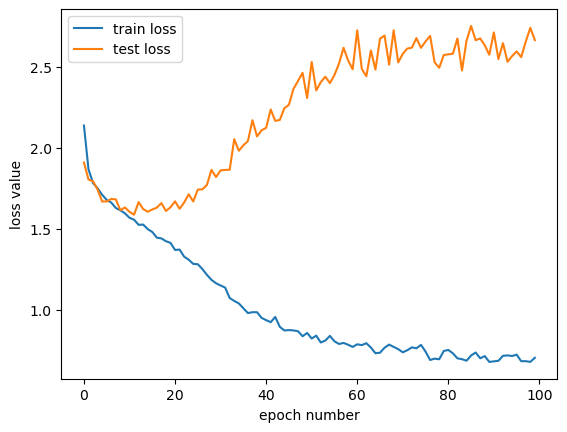

In [5]:
plt.plot(base_model.history["loss"], label = "train loss");
plt.plot(base_model.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

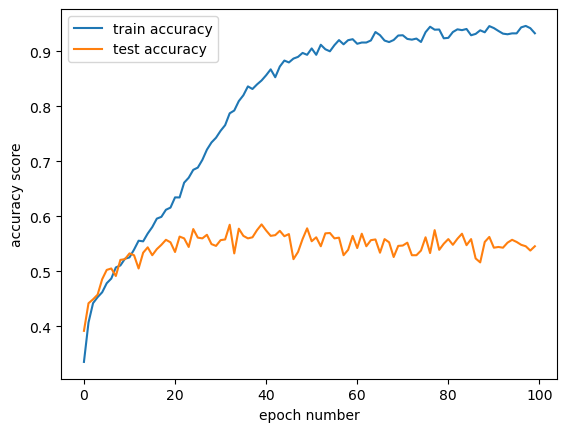

In [6]:
plt.plot(base_model.history["accuracy"], label = "train accuracy");
plt.plot(base_model.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

It'll help us to know what's getting mislabeled. Let's do a confusion matrix using the types we've inputted previously.

 1/48 [..............................] - ETA: 5s

2023-03-29 10:20:01.403228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 3s 59ms/step


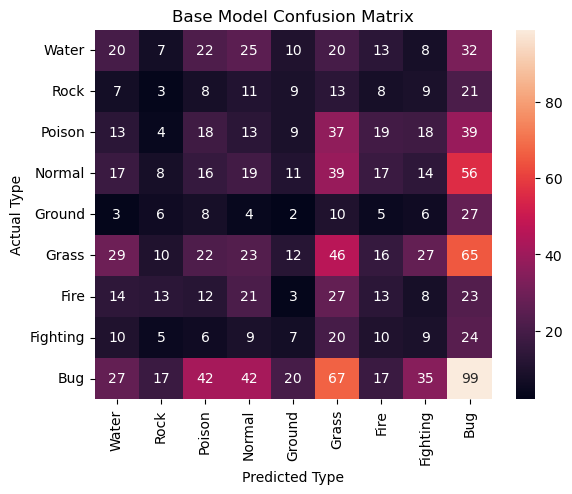

In [7]:
# new labels
types = ["Water", "Rock", "Poison", "Normal", "Ground", "Grass", "Fire", "Fighting", "Bug"]

# get predicted values
Y_pred = model.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Base Model Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

It looks like Bug and Grass are often mistaken for each other, which makes sense. Usually these types overlap considerably with some Pokémon having both types. They're also often both green-colored.

In fact, our Bug and Grass types overall seem to be having the most issues. The model is mistaking too many other types for these ones.

## Model 2

While train accuracy seems to be going up with each epoch, it looks like test accuracy is holding steady around 53-55% despite the number of epochs. 

We need to solve for overfitting. To do this we can increase regularization, add more convolutional layers, decrease learning rate, and/or change the optimization algorithm from adam to something like SGD.

To begin out iterative process, we'll start by increasing regularization with Dropout and early stopping.

In [12]:
es = EarlyStopping(monitor = "val_accuracy", mode = "min", verbose = 1, patience = 15)
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(Flatten())
model2.add(Dense(32, activation='relu', kernel_regularizer = reg))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation='relu', kernel_regularizer = reg))
model2.add(Dense(9, activation='softmax', kernel_regularizer = reg))
model2.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
model_2 = model2.fit(train_generator, verbose = 1, validation_data = test_generator, epochs = 100,
                    callbacks=[es])

Epoch 1/100
  1/192 [..............................] - ETA: 1:05 - loss: 2.8090 - accuracy: 0.0938

2023-03-29 10:26:18.734484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 25/192 [==>...........................] - ETA: 9s - loss: 2.6129 - accuracy: 0.2000

/opt/homebrew/Caskroom/miniforge/base/envs/middle-earth/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


192/192 [==============================] - ETA: 0s - loss: 2.2323 - accuracy: 0.2294

2023-03-29 10:26:32.789752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 17s 89ms/step - loss: 2.2323 - accuracy: 0.2294 - val_loss: 2.0632 - val_accuracy: 0.2386
Epoch 2/100
192/192 [==============================] - 17s 88ms/step - loss: 2.0495 - accuracy: 0.2752 - val_loss: 1.9924 - val_accuracy: 0.3038
Epoch 3/100
192/192 [==============================] - 17s 88ms/step - loss: 2.0112 - accuracy: 0.2948 - val_loss: 1.9635 - val_accuracy: 0.3025
Epoch 4/100
192/192 [==============================] - 17s 87ms/step - loss: 1.9791 - accuracy: 0.2940 - val_loss: 1.9556 - val_accuracy: 0.3129
Epoch 5/100
192/192 [==============================] - 17s 89ms/step - loss: 1.9616 - accuracy: 0.2953 - val_loss: 1.9210 - val_accuracy: 0.3390
Epoch 6/100
192/192 [==============================] - 17s 90ms/step - loss: 1.9512 - accuracy: 0.3209 - val_loss: 1.9220 - val_accuracy: 0.3449
Epoch 7/100
192/192 [==============================] - 16s 85ms/step - loss: 1.9340 - accuracy: 0.3200 - val_loss: 1.9032 - val_accuracy: 0.34

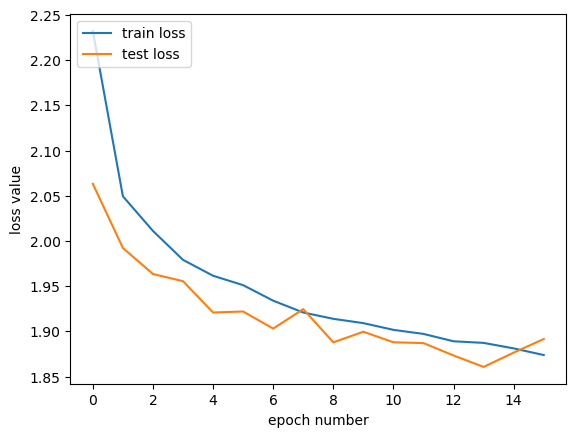

In [13]:
plt.plot(model_2.history["loss"], label = "train loss");
plt.plot(model_2.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

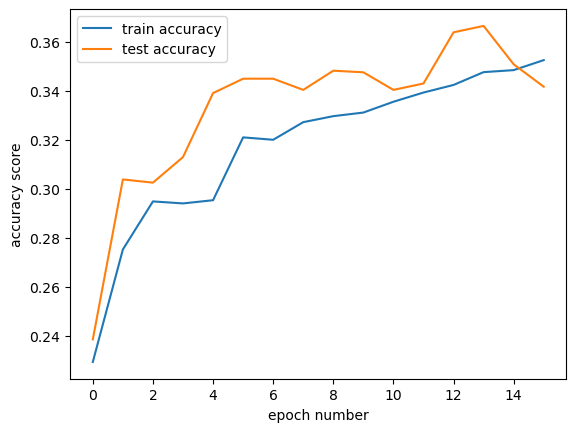

In [14]:
plt.plot(model_2.history["accuracy"], label = "train accuracy");
plt.plot(model_2.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

While overfit no longer seems to be an issue, our accuracy is much lower than before. Let's use a confusion matrix to see what the model is getting wrong.

 2/48 [>.............................] - ETA: 4s

2023-03-29 10:32:25.997149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 3s 58ms/step


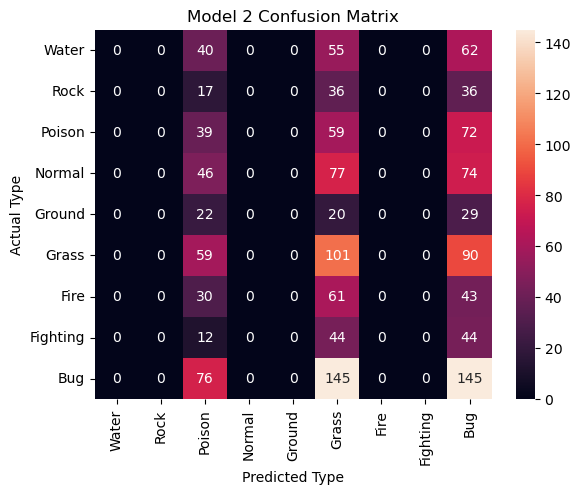

In [15]:
# get predicted values
Y_pred = model2.predict(test_generator, 1534// 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 2 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

The type mislabeling is out of control! Everything is now being called a Bug, Grass, or Poison type despite what it looks like. Not good. Let's go back to Model 1 and try something else.

## Model 3

For Model 3, we're going to use Model 1 again but swap adam for SGD.

In [16]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(Flatten())
model3.add(Dense(32, activation='relu', kernel_regularizer = reg))
model3.add(Dense(16, activation='relu', kernel_regularizer = reg))
model3.add(Dense(9, activation='softmax', kernel_regularizer = reg))

model3.compile(optimizer='sgd', loss=cce,  metrics=['accuracy'])
model_3 = model3.fit(train_generator, verbose=1, validation_data = test_generator, epochs=50, callbacks=[es])

Epoch 1/50


2023-03-29 10:33:17.694247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 28/192 [===>..........................] - ETA: 9s - loss: 2.4490 - accuracy: 0.1853

/opt/homebrew/Caskroom/miniforge/base/envs/middle-earth/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


192/192 [==============================] - ETA: 0s - loss: 2.3842 - accuracy: 0.2287

2023-03-29 10:33:30.408121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 16s 80ms/step - loss: 2.3842 - accuracy: 0.2287 - val_loss: 2.3377 - val_accuracy: 0.2738
Epoch 2/50
192/192 [==============================] - 15s 80ms/step - loss: 2.2981 - accuracy: 0.2841 - val_loss: 2.2150 - val_accuracy: 0.3416
Epoch 3/50
192/192 [==============================] - 15s 79ms/step - loss: 2.1958 - accuracy: 0.3200 - val_loss: 2.1131 - val_accuracy: 0.3696
Epoch 4/50
192/192 [==============================] - 15s 80ms/step - loss: 2.1309 - accuracy: 0.3443 - val_loss: 2.0627 - val_accuracy: 0.3683
Epoch 5/50
192/192 [==============================] - 15s 80ms/step - loss: 2.0796 - accuracy: 0.3707 - val_loss: 2.0072 - val_accuracy: 0.4042
Epoch 6/50
192/192 [==============================] - 16s 81ms/step - loss: 2.0233 - accuracy: 0.3975 - val_loss: 1.9895 - val_accuracy: 0.4140
Epoch 7/50
192/192 [==============================] - 15s 79ms/step - loss: 1.9912 - accuracy: 0.4017 - val_loss: 1.9860 - val_accuracy: 0.4055
Epo

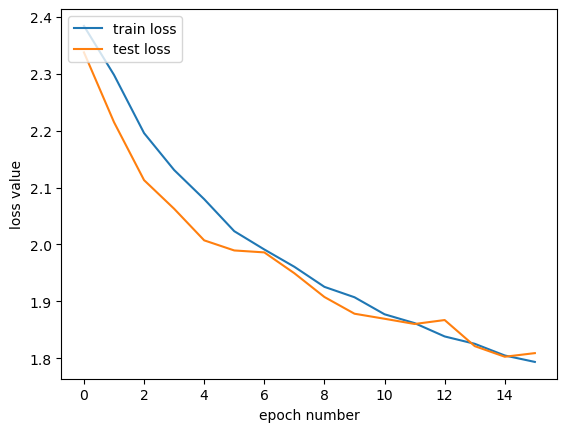

In [17]:
plt.plot(model_3.history["loss"], label = "train loss");
plt.plot(model_3.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

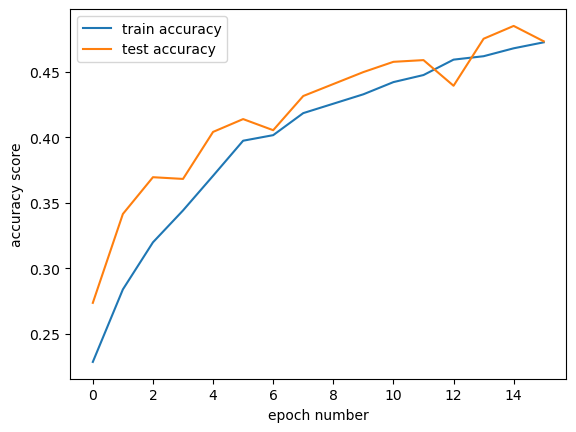

In [18]:
plt.plot(model_3.history["accuracy"], label = "train accuracy");
plt.plot(model_3.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

Overfitting seems to be relatively solved at this point, though accuracy on the whole is down. 

 2/48 [>.............................] - ETA: 4s

2023-03-29 10:37:35.051540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 3s 57ms/step


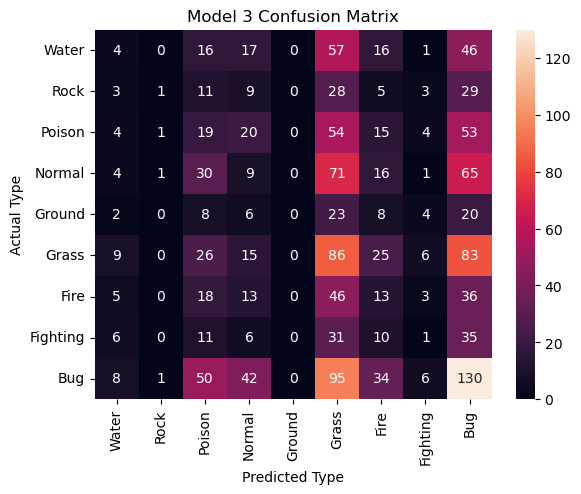

In [19]:
# get predicted values
Y_pred = model3.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 3 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

We're still not seeing an overal trend towards accurate predictions and this time nothing was labeled as Ground type.

## Model 4

Accuracy on the whole was best in our first model using the adam algorithm. What we can try next is decreasing the learning rate and/or adding more layers.


In [21]:
opt = keras.optimizers.Adam(learning_rate = 0.0001)

model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(Flatten())
model4.add(Dense(32, activation='relu', kernel_regularizer = reg))
model4.add(Dense(16, activation='relu', kernel_regularizer = reg))
model4.add(Dense(9, activation='softmax', kernel_regularizer = reg))

model4.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

model_4 = model4.fit(train_generator, verbose=1, validation_data = test_generator, epochs=100, callbacks = [es])

Epoch 1/100
  1/192 [..............................] - ETA: 58s - loss: 2.4549 - accuracy: 0.0625

2023-03-29 10:38:43.562486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/192 [===================>..........] - ETA: 4s - loss: 2.3590 - accuracy: 0.2272

/opt/homebrew/Caskroom/miniforge/base/envs/middle-earth/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


192/192 [==============================] - ETA: 0s - loss: 2.3172 - accuracy: 0.2588

2023-03-29 10:38:56.340589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 16s 81ms/step - loss: 2.3172 - accuracy: 0.2588 - val_loss: 2.1925 - val_accuracy: 0.3390
Epoch 2/100
192/192 [==============================] - 17s 87ms/step - loss: 2.1360 - accuracy: 0.3271 - val_loss: 2.0523 - val_accuracy: 0.3592
Epoch 3/100
192/192 [==============================] - 17s 88ms/step - loss: 2.0177 - accuracy: 0.3612 - val_loss: 1.9643 - val_accuracy: 0.4087
Epoch 4/100
192/192 [==============================] - 16s 85ms/step - loss: 1.9293 - accuracy: 0.3992 - val_loss: 1.8961 - val_accuracy: 0.4250
Epoch 5/100
192/192 [==============================] - 15s 81ms/step - loss: 1.8760 - accuracy: 0.4291 - val_loss: 1.8420 - val_accuracy: 0.4544
Epoch 6/100
192/192 [==============================] - 16s 84ms/step - loss: 1.8331 - accuracy: 0.4423 - val_loss: 1.8296 - val_accuracy: 0.4518
Epoch 7/100
192/192 [==============================] - 15s 79ms/step - loss: 1.8029 - accuracy: 0.4516 - val_loss: 1.7956 - val_accuracy: 0.46

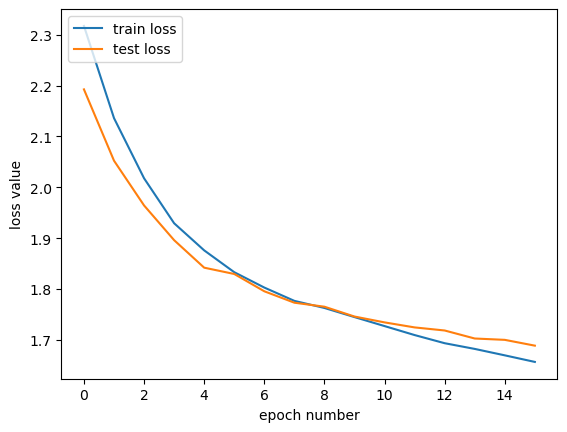

In [23]:
plt.plot(model_4.history["loss"], label = "train loss");
plt.plot(model_4.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

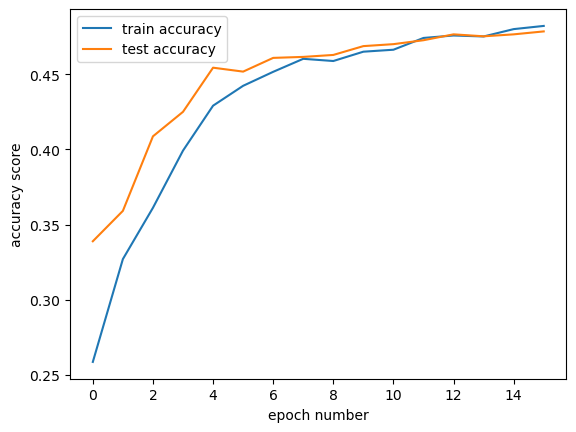

In [24]:
plt.plot(model_4.history["accuracy"], label = "train accuracy");
plt.plot(model_4.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

Again our test accuracy seems to be stalling out around 55% though our overfit is less this time.

 3/48 [>.............................] - ETA: 2s

2023-03-29 10:44:33.930165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 3s 58ms/step


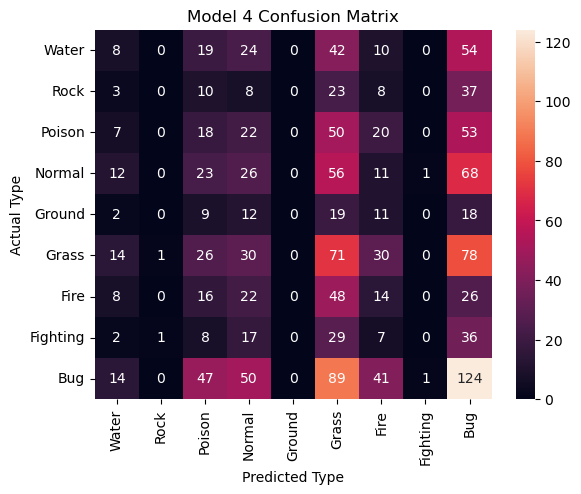

In [26]:
# get predicted values
Y_pred = model4.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 4 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

Again, nothing is being labled as Ground and few are being labeled as Fighting or Rock while Grass and Bug labeling is mostly wrong.

The last thing we can try is adding more layers.

## Model 5

In [29]:
reg = l2(3e-3)
opt = keras.optimizers.Adam()

model5 = Sequential()
model5.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3)))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Conv2D(32, (3, 3), activation='relu'))
model5.add(Flatten())
model5.add(Dense(32, activation='relu', kernel_regularizer = reg))
model5.add(Dense(32, activation='relu', kernel_regularizer = reg))
model5.add(Dense(32, activation='relu', kernel_regularizer = reg))
model5.add(Dense(32, activation='relu', kernel_regularizer = reg))
model5.add(Dense(32, activation='relu', kernel_regularizer = reg))
model5.add(Dense(32, activation='relu', kernel_regularizer = reg))
model5.add(Dense(16, activation='relu', kernel_regularizer = reg))
model5.add(Dense(16, activation='relu', kernel_regularizer = reg))
model5.add(Dense(16, activation='relu', kernel_regularizer = reg))
model5.add(Dense(16, activation='relu', kernel_regularizer = reg))
model5.add(Dense(16, activation='relu', kernel_regularizer = reg))
model5.add(Dense(8, activation='relu', kernel_regularizer = reg))
model5.add(Dense(8, activation='relu', kernel_regularizer = reg))
model5.add(Dense(8, activation='relu', kernel_regularizer = reg))
model5.add(Dense(8, activation='relu', kernel_regularizer = reg))
model5.add(Dense(9, activation='softmax', kernel_regularizer = reg))

model5.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

model_5 = model5.fit(train_generator, verbose = 1, validation_data = test_generator, epochs=100, callbacks = [es])

Epoch 1/100


2023-03-29 10:48:04.998051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - ETA: 0s - loss: 2.5961 - accuracy: 0.2131

2023-03-29 10:48:19.571429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 18s 89ms/step - loss: 2.5961 - accuracy: 0.2131 - val_loss: 2.3045 - val_accuracy: 0.2386
Epoch 2/100
192/192 [==============================] - 17s 87ms/step - loss: 2.2279 - accuracy: 0.2336 - val_loss: 2.1812 - val_accuracy: 0.2386
Epoch 3/100
192/192 [==============================] - 17s 88ms/step - loss: 2.1329 - accuracy: 0.2349 - val_loss: 2.0914 - val_accuracy: 0.2503
Epoch 4/100
192/192 [==============================] - 18s 91ms/step - loss: 2.0845 - accuracy: 0.2540 - val_loss: 2.0828 - val_accuracy: 0.2699
Epoch 5/100
192/192 [==============================] - 17s 88ms/step - loss: 2.0638 - accuracy: 0.2642 - val_loss: 2.0782 - val_accuracy: 0.2653
Epoch 6/100
192/192 [==============================] - 17s 90ms/step - loss: 2.0469 - accuracy: 0.2677 - val_loss: 2.0269 - val_accuracy: 0.2718
Epoch 7/100
192/192 [==============================] - 17s 88ms/step - loss: 2.0197 - accuracy: 0.2839 - val_loss: 2.0258 - val_accuracy: 0.29

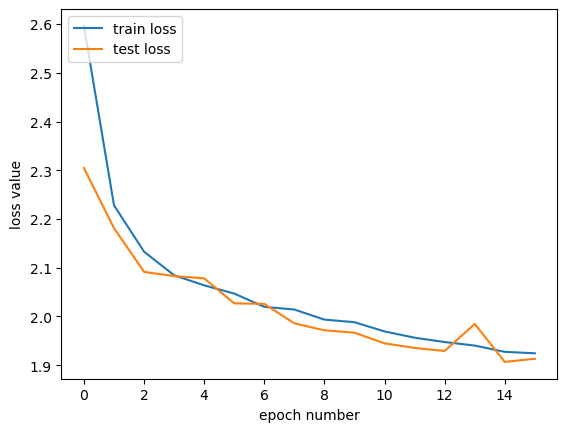

In [30]:
plt.plot(model_5.history["loss"], label = "train loss");
plt.plot(model_5.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

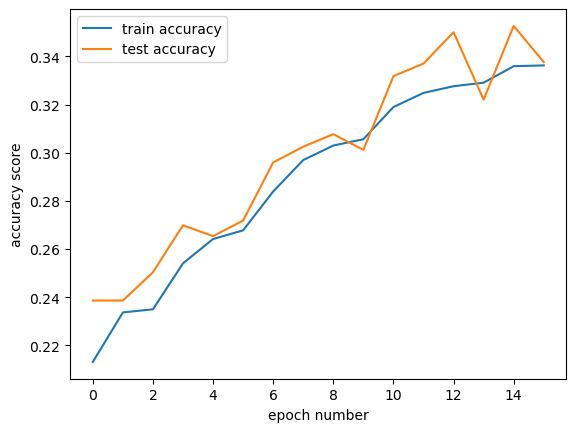

In [31]:
plt.plot(model_5.history["accuracy"], label = "train accuracy");
plt.plot(model_5.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

 2/48 [>.............................] - ETA: 2s

2023-03-29 10:53:22.107554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 3s 60ms/step


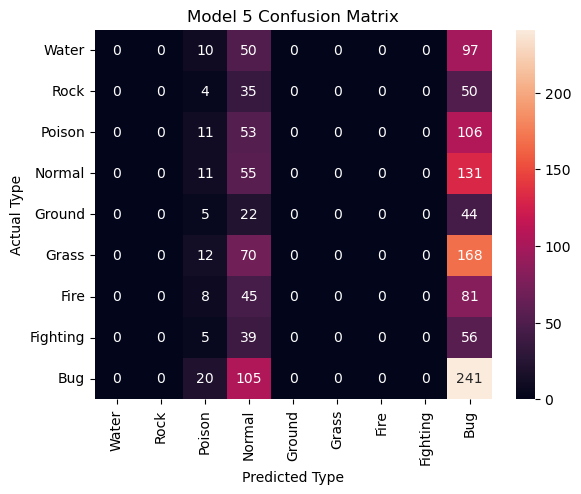

In [32]:
# get predicted values
Y_pred = model5.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 5 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

It seems like with more layers, the model is defaulting to labeling almost everything as Bug or Normal types.